In [1]:
import Pkg
Pkg.add("PrettyTables")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [2]:
using DataFrames, FredData, XLSX, SHA, Dates, CSV, TimeSeries, StatsBase, HiddenMarkovModels, Distributions, Plots, PrettyTables

In [3]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    sigma = rand(Uniform(0,0.25))
    means = rand(Uniform(-0.25,0.25))
    return Normal(means,sigma)
end

function train_hmm(data, n_scenarios = 2)

    function guess_distribution()
        sigma = rand(Uniform(0,0.25))
        means = rand(Uniform(-0.25,0.25))
        return Normal(means,sigma)
    end
    
    init_guess = guess_init(n_scenarios)
    guess_matrix = guess_tmatrix(n_scenarios)
    guess_dist = [guess_distribution() for s in 1:n_scenarios]
    hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
    return hmm_est, loglikelihood_evolution = baum_welch(hmm_guess, data);
end 

train_hmm (generic function with 2 methods)

In [4]:
function regime_summary(loglikehood,hmm_est, freq = 1)
        tm = transition_matrix(hmm_est)
        
   return DataFrame(Dict(
      "mu1" => mean(obs_distributions(hmm_est)[1]) * freq,
      "sig1" => std(obs_distributions(hmm_est)[1]) *  freq^0.5,
      "mu2" => mean(obs_distributions(hmm_est)[2]) * freq,
      "sig2" => std(obs_distributions(hmm_est)[2]) * freq^0.5,       
      "p11" =>  tm[1,1],
      "p21" =>  tm[2,1],
      "loglikehood" => last(loglikehood),
      "prob1" =>  tm[2,1]/(tm[1,2]+tm[2,1])
      
  )) 
  end

regime_summary (generic function with 2 methods)

In [5]:
function regime_summary_2(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    n_regimes = length(initialization(hmm_est))
    dict = Dict()
   
    return n_regimes
      
end


regime_summary_2 (generic function with 2 methods)

In [6]:
source_data = TimeArray(CSV.File("assets_data_03.24.csv", delim=';', dateformat=Dict("Date" => "dd.mm.yyyy"), decimal=','),timestamp=:Date)
returns = percentchange(source_data, :log)

615×8 TimeArray{Union{Missing, Float64}, 2, Date, Matrix{Union{Missing, Float64}}} 1973-01-31 to 2024-03-31
┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬─────────
│            │ ACWI_Net   │ USDPLN      │ ACWI_Net_PLN │ CPI_USA      │ CPI_PL ⋯
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼─────────
│ 1973-01-31 │    missing │     missing │      missing │   0.00235067 │     mi ⋯
│ 1973-02-28 │    missing │     missing │      missing │   0.00701905 │     mi ⋯
│ 1973-03-31 │    missing │     missing │      missing │   0.00927727 │     mi ⋯
│ 1973-04-30 │    missing │     missing │      missing │   0.00690598 │     mi ⋯
│ 1973-05-31 │    missing │     missing │      missing │   0.00685862 │     mi ⋯
│ 1973-06-30 │    missing │     missing │      missing │    0.0068119 │     mi ⋯
│ 1973-07-31 │    missing │     missing │      missing │   0.00225501 │     mi ⋯
│ 1973-08-31 │    missing │     missing │      missing │    0.0179014 │     mi ⋯
│

In [7]:
stats = summarystats.(eachcol(values(returns)))

stats = DataFrame([stats[1],stats[2],stats[3]])


Row,mean,sd,min,q25,median,q75,max,nobs,nmiss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00622469,0.0443616,-0.220834,-0.0181497,0.0124942,0.0330787,0.116238,615,180
2,0.000397277,0.0371301,-0.094026,-0.0247304,-0.00190905,0.0234364,0.166496,615,300
3,0.00581535,0.0380711,-0.111985,-0.0159863,0.00790446,0.0323534,0.105947,615,300


In [8]:
acwi_long = identity.(values(from(returns[:ACWI_Net,],Date(1988,01,01))))
hmm_est, loglikehood = train_hmm(acwi_long,2)
println("ACWI long 2")
regime_summary(loglikehood,hmm_est,12)

ACWI long 2


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,774.685,-0.0115736,0.16069,0.941969,0.0597848,0.507444,0.195713,0.0873571


In [9]:
hmm_est, loglikehood = train_hmm(acwi_long,4)
println("ACWI long 4")
regime_summary(loglikehood,hmm_est,12)

ACWI long 4


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,782.292,-0.104798,0.299722,0.214906,0.694071,0.590927,0.0823117,0.0598397


In [10]:
acwi_98 = identity.(values(from(returns[:ACWI_Net],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_98,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,550.318,0.173304,-0.0297016,0.932856,0.0563131,0.456133,0.0833255,0.20228


In [11]:
acwi_03 = identity.(values(from(returns[:ACWI_Net],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,459.165,0.168604,-0.0133009,0.937796,0.0806212,0.564474,0.0812753,0.210603


In [12]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est_98_PLN, loglikehood = train_hmm(acwi_pln_98,2)
regime_summary(loglikehood,hmm_est_98_PLN,1)

mean 0.06978414756872021, std: 0.13188218245803085


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,603.335,-0.0133882,0.0134086,0.875439,0.0496787,0.285117,0.0514809,0.0276529


In [13]:
acwi_pln_01 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_01,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,543.406,0.143817,-0.149773,0.958623,0.115474,0.7362,0.0911434,0.180198


In [14]:
acwi_pln_03 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,508.416,-0.0952002,0.143987,0.837684,0.045082,0.21737,0.178229,0.0905749


In [15]:
usdpln_03 = identity.(values(from(returns[:USDPLN ],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(usdpln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,480.778,1.5552,-0.0320627,1.39451e-14,0.0219804,0.0215076,0.0736746,0.116616


In [16]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    corr = Matrix(1.0I,2,2)
    sigma = [rand(Uniform(0,0.25)),rand(Uniform(0,0.035))]
    means = [rand(Uniform(-0.5,0.5)),rand(Uniform(-0.01,0.12))]
    cov = cor2cov(corr,sigma)
    return MvNormal(means,cov)
end

using LinearAlgebra

In [17]:
acwi_and_pln = identity.(values(from(returns[:ACWI_Net_PLN, :USDPLN],Date(2001,01,01))))
n_scenarios = 2


init_guess = guess_init(n_scenarios)
guess_matrix = guess_tmatrix(n_scenarios)
guess_dist = [guess_distribution() for s in 1:n_scenarios]
hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
println(hmm_guess)
hmm_est_concat, _ = baum_welch(hmm_guess, eachrow(acwi_and_pln));

Hidden Markov Model with:
 - initialization: [0.29292929292929293, 0.7070707070707071]
 - transition matrix: [0.30973451327433627 0.6902654867256637; 0.6588235294117647 0.3411764705882353]
 - observation distributions: [FullNormal(
dim: 2
μ: [-0.3844188275276711, 0.07780487346882703]
Σ: [0.020501322270595826 0.0; 0.0 4.713257314066823e-5]
)
, FullNormal(
dim: 2
μ: [-0.36071599047800984, 0.019259146530080005]
Σ: [0.016563372492225985 0.0; 0.0 0.0006944647797995611]
)
]


In [18]:
dist1 = obs_distributions(hmm_est_concat)[1]
dist2 = obs_distributions(hmm_est_concat)[2]

mean1 = mean(dist1) .* 12
mean2 = mean(dist2) .* 12

std1 = sqrt.(var(dist1)) .* 12^0.5
std2 = sqrt.(var(dist2)) .* 12^0.5
display("means")
display([mean1 mean2])
display("std")
display([std1 std2])
display("corr")
cor1 = cor(dist1)
display(cor1)
cor2 = cor(dist2)
display(cor2)


"means"

2×2 Matrix{Float64}:
 0.625333   0.0522188
 0.891931  -0.0141613

"std"

2×2 Matrix{Float64}:
 0.0615123  0.128248
 0.0609366  0.127258

"corr"

2×2 Matrix{Float64}:
 1.0       0.999934
 0.999934  1.0

2×2 Matrix{Float64}:
 1.0      0.20276
 0.20276  1.0

In [19]:
acwi_short = identity.(values(from(returns[:ACWI_Net],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
obs_distributions(hmm_est)

2-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.013891956033510509, σ=0.023420925956529573)
 Normal{Float64}(μ=-0.003135476265857959, σ=0.059348635513330035)

In [20]:
acwi_short = identity.(from(returns[:ACWI_Net],Date(2001,01,01)))
hmm_est, loglikehood = train_hmm(values(acwi_short),2)
HMM(initialization(hmm_est), transition_matrix(hmm_est), obs_distributions(hmm_est))
states,_ = viterbi(hmm_est,values(acwi_short))
states = Float64.(states)

279-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [21]:
acwi_states = merge(acwi_short,identity.(from((returns[:USDPLN]),Date(1998,01,01))),TimeArray(timestamp(acwi_short),states))
CSV.write("states",acwi_states)


"states"

In [22]:
first_regime = acwi_states[findwhen(acwi_states[:A] .== 1.0)]
second_regime = acwi_states[findwhen(acwi_states[:A] .== 2.0)]

println("First usd pln")
println(mean(values(first_regime[:USDPLN]))*12)
println(std(values(first_regime[:USDPLN]))*12^0.5)
println(cor(values(first_regime[:USDPLN]),values(first_regime[:ACWI_Net ])))

println("Second usd pln")
println(mean(values(second_regime[:USDPLN]))*12)
println(std(values(second_regime[:USDPLN]))*12^0.5)
println(cor(values(second_regime[:USDPLN]),values(second_regime[:ACWI_Net])))

First usd pln
-0.02979151262801521
0.10498902329177802
-0.5525433853025217
Second usd pln
0.02323905518920558
0.14920806835446282
-0.6632535242025056


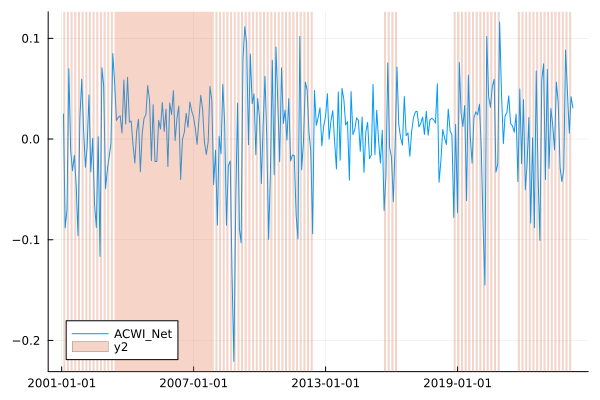

In [23]:
plot(acwi_states[:ACWI_Net ])
vspan!(findwhen(acwi_states[:A] .== 2.0),alpha = 0.3)

In [24]:
sims = [0.06 0.13 -0.23 0.3 -0.05 0.15; 0.15 -0.23 0.06 0.13 0.3 -0.05; -0.05 0.3 -0.23 0.15 0.06 0.13]

function annualise(scenarios:: Matrix, shift=2)
   
    periods = floor.(Int, size(scenarios)[2]/shift)
    result = zeros(size(scenarios)[1],periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[:,p] .= sum(scenarios[:,start:en],dims=2)
    end 
    return result
   
end

annualise(sims,2)


3×3 Matrix{Float64}:
  0.19   0.07  0.1
 -0.08   0.19  0.25
  0.25  -0.08  0.19

In [25]:
function annualise(scenarios:: Vector, shift=2)
   
    periods = floor.(Int, size(scenarios)[1]/shift)
    result = zeros(periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[p] = sum(scenarios[start:en])
    end  
    return result
   
end

annualise(sims[1,:],2)

3-element Vector{Float64}:
 0.19
 0.06999999999999998
 0.09999999999999999

In [26]:
function print_percentiles(X, perc)
    years = size(X)[2]
    simulation_perc = zeros(length(perc),years)

    for t in 1:years
        simulation_perc[:,t] = quantile(X[:,t],perc)
    end
    pretty_table(simulation_perc, backend = Val(:html),header=1:years, row_labels=perc)
end

print_percentiles (generic function with 1 method)

In [27]:
using ScenTrees, SDDP

In [28]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12)")
println("std $(std(acwi_pln_98)*12^0.5)")

mean 0.06978414756872021
std 0.13188218245803085


In [29]:
println("mean: ",expm1(0.0698))
println("std: ",expm1(0.1319))

mean: 0.07229370106669933
std: 0.14099421414065977


In [30]:
println("mean $(mean(acwi_pln_98))")
println("std $(std(acwi_pln_98))")

mean 0.005815345630726685
std 0.03807110677172973


In [31]:
println("mean: ",expm1(0.0058))
println("std: ",expm1(0.0380))

mean: 0.005816852565873483
std: 0.03873123287849773


In [32]:
years = 15
n_steps = years * 12
n_scenarios = 100000
simulations = rand(Normal(0.0058,0.0387),(n_scenarios,n_steps))
simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.243122,-0.242788,-0.243419,-0.244043,-0.243831,-0.243127,-0.241295,-0.242908,-0.245036,-0.243068,-0.239986,-0.242552,-0.242983,-0.242359,-0.242316
0.025,-0.193366,-0.193527,-0.193467,-0.193976,-0.193019,-0.193144,-0.192311,-0.194087,-0.192934,-0.192881,-0.192717,-0.193433,-0.19399,-0.193057,-0.193893
0.16,-0.0634643,-0.0634574,-0.0641911,-0.0638307,-0.0634762,-0.0635377,-0.0639907,-0.0635329,-0.0627527,-0.0627231,-0.0628373,-0.0637152,-0.0641547,-0.0638134,-0.0644609
0.5,0.0696974,0.0700402,0.069982,0.0693588,0.0689667,0.0705812,0.0696134,0.070107,0.0692569,0.0698791,0.0694711,0.0695652,0.0694554,0.0694265,0.0700292
0.84,0.203736,0.202735,0.203195,0.202238,0.201973,0.203342,0.202691,0.202557,0.203228,0.203637,0.20348,0.203167,0.203194,0.20258,0.202942
0.975,0.33254,0.331436,0.332496,0.332803,0.331007,0.333357,0.332178,0.332259,0.333051,0.331487,0.33488,0.331602,0.331575,0.330369,0.331789
0.99,0.381264,0.380961,0.38111,0.381162,0.382686,0.382946,0.380992,0.38059,0.38063,0.381642,0.382041,0.378449,0.381397,0.380913,0.381573


In [33]:
norm_moments = Dict(
    :mean => mean(simulations[:,1]),
    :min => minimum(simulations[:,1]),
    :max => maximum(simulations[:,1]),
    :median => median(simulations[:,1]),
    :std => std(simulations[:,1]),
    :var => var(simulations[:,1]),
    :skew => skewness(simulations[:,1]),
    :kurtosis => kurtosis(simulations[:,1])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.186495
  :median   => 0.00561115
  :std      => 0.0388714
  :mean     => 0.00577633
  :var      => 0.00151099
  :kurtosis => -0.00877321
  :skew     => -0.00272181
  :min      => -0.159944

In [34]:
print_percentiles(annualise(simulations,60),[.1, .3, .5, .7, .9]) 

,1,2,3
0.1,-0.0362997,-0.037311,-0.0362426
0.3,0.189874,0.193175,0.190833
0.5,0.347592,0.351388,0.348761
0.7,0.504209,0.506393,0.505524
0.9,0.733245,0.733267,0.73428


In [35]:
function simulator()
    scenarios = rand(Normal(0.0723,0.1410),180)
    return scenarios #annualise(scenarios,12)
end

graph = SDDP.MarkovianGraph(simulator; budget = fill(5,15), scenarios = 100000);
graph


Root
 (0, 0.0)
Nodes
 (1, -0.08639270389116814)
 (1, 0.06477206687659369)
 (1, 0.1402571299762901)
 (1, 0.18682848475300634)
 (1, 0.3889467062402691)
 (2, -0.09054473765743959)
 (2, 0.02932737932313293)
 (2, 0.07677807650076973)
 (2, 0.18331947225310022)
 (2, 0.39193305266890577)
 (3, -0.11408662646420387)
 (3, -0.019685154812539244)
 (3, 0.07309154498110948)
 (3, 0.1831228109859842)
 (3, 0.3906357752132761)
 (4, -0.14089906934938382)
 (4, -0.021426323737175082)
 (4, 0.07359887560350048)
 (4, 0.1830803460120987)
 (4, 0.3881620538927593)
 (5, -0.08489823135323867)
 (5, 0.06670406558729478)
 (5, 0.16567859179321473)
 (5, 0.26604373842027074)
 (5, 0.40019413742972976)
 (6, -0.0882497129738734)
 (6, 0.038304150903197526)
 (6, 0.07704913741399157)
 (6, 0.183184343963474)
 (6, 0.38826342709109524)
 (7, -0.09163488837790065)
 (7, 0.017102399061261372)
 (7, 0.07669459316300409)
 (7, 0.18290522003474438)
 (7, 0.38938131420249056)
 (8, -0.0856620147768464)
 (8, 0.06278343840083693)
 (8, 0.083082

In [36]:
years = 15
n_steps = years*12
n_scenarios = 5000

hmm = HMM([1.,0],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.293283,-0.403521,-0.402793,-0.377236,-0.382,-0.425018,-0.411768,-0.398628,-0.425759,-0.415864,-0.400697,-0.415261,-0.402088,-0.393269,-0.389289
0.025,-0.21596,-0.313205,-0.314931,-0.305613,-0.298686,-0.322713,-0.322343,-0.323955,-0.337784,-0.32868,-0.326969,-0.320785,-0.326585,-0.307107,-0.299016
0.16,-0.0166096,-0.0835541,-0.0856626,-0.086998,-0.087507,-0.0959942,-0.0953435,-0.0996706,-0.0942209,-0.0899696,-0.0910831,-0.091027,-0.0858771,-0.0953062,-0.085689
0.5,0.123403,0.0981234,0.0984762,0.0980294,0.0962096,0.0979348,0.0897397,0.0950528,0.0906293,0.0994891,0.0978235,0.0982841,0.096688,0.0942447,0.0926797
0.84,0.235966,0.224534,0.220305,0.224027,0.22487,0.223336,0.216469,0.22142,0.221488,0.220495,0.222056,0.223345,0.221945,0.220607,0.218857
0.975,0.339174,0.33337,0.327363,0.331753,0.329505,0.32816,0.330462,0.324632,0.326871,0.329399,0.330236,0.326218,0.33303,0.333074,0.328877
0.99,0.381979,0.378439,0.369939,0.372065,0.366431,0.364689,0.366206,0.363487,0.36446,0.370788,0.371641,0.369825,0.375783,0.3713,0.3703


In [37]:
print_percentiles(annualise(simulations,60),[.1, .3, .5, .7, .9]) 

,1,2,3
0.1,-0.113667,-0.206796,-0.178408
0.3,0.222084,0.152711,0.16117
0.5,0.429957,0.374385,0.378325
0.7,0.629745,0.57327,0.590316
0.9,0.871825,0.823165,0.834469


In [38]:
years = 10
n_steps = years*12
n_scenarios = 100000

hmm = HMM([1.,0],transition_matrix(hmm_est_98_PLN),obs_distributions(hmm_est_98_PLN))
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10
0.05,-0.348135,-0.26495,-0.245207,-0.243679,-0.24237,-0.242642,-0.243038,-0.244811,-0.244374,-0.244791
0.25,-0.146352,-0.0372495,-0.0229129,-0.0215825,-0.0220176,-0.02032,-0.0211397,-0.0231641,-0.0212715,-0.0203444
0.5,-0.0155284,0.0853683,0.0941183,0.0941607,0.09386,0.0948554,0.094062,0.0932577,0.0950038,0.0946836
0.75,0.100519,0.177686,0.1832,0.183344,0.182551,0.182977,0.184388,0.182877,0.183903,0.182955
0.95,0.243653,0.291399,0.293322,0.295331,0.294262,0.294008,0.296018,0.293998,0.295432,0.294482


In [39]:
t = 5
hmm_moments = Dict(
    :mean => mean(simulations_ann[:,t]),
    :med => median(simulations_ann[:,t]),
    :min => minimum(simulations[:,t]),
    :max => maximum(simulations[:,t]),
    :std => std(simulations_ann[:,t]),
    :var => var(simulations_ann[:,t]),
    :skew => skewness(simulations_ann[:,t]),
    :kurtosis => kurtosis(simulations_ann[:,t])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.211592
  :std      => 0.163191
  :mean     => 0.0687025
  :var      => 0.0266313
  :med      => 0.09386
  :kurtosis => 0.711806
  :skew     => -0.762085
  :min      => -0.227633

In [40]:
function regime_sampler_ann()    
    hmm = HMM([1,0.],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])    
    return annualise(rand(hmm,15*12)[2], 12)
end

regime_sampler_ann()


15-element Vector{Float64}:
  0.06778713609571285
 -0.37674556210463955
  0.19760288439386875
 -0.18513308837552372
 -0.02400417582253697
  0.06224804135493101
 -0.04568328186171611
 -0.25925704719078224
 -0.08795738774093166
  0.19247752409714505
 -0.22681532458783374
 -0.07512932556935688
  0.0939561285540993
  0.11219519964578573
  0.27106906716347084

In [43]:
Base.LinRange(-3.5,3.5,8)

8-element LinRange{Float64, Int64}:
 -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5

In [85]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est, loglikehood = train_hmm(acwi_pln_98,2)
hmm_est

mean 0.06978414756872021, std: 0.13188218245803085


Hidden Markov Model with:
 - initialization: [1.0, 3.978144708088232e-35]
 - transition matrix: [0.9503269865480146 0.04967301345198542; 0.12452802991347076 0.8754719700865292]
 - observation distributions: [Normal{Float64}(μ=0.013408378826971776, σ=0.027652555862970198), Normal{Float64}(μ=-0.013384843801186836, σ=0.05148033633426641)]

In [86]:
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,603.335,0.160901,-0.160618,0.950327,0.124528,0.714852,0.0957913,0.178333


In [87]:
init = [1., 0]
trans = [0.95 0.05; 0.12 0.88]
dists = [Normal(0.0134, 0.0277), Normal(-0.0134, 0.0515)]
hmm = HMM(init, trans, dists)

Hidden Markov Model with:
 - initialization: [1.0, 0.0]
 - transition matrix: [0.95 0.05; 0.12 0.88]
 - observation distributions: [Normal{Float64}(μ=0.0134, σ=0.0277), Normal{Float64}(μ=-0.0134, σ=0.0515)]

In [88]:
n_scenarios = 2000
years = 30
n_steps = years * 12

long_obs_seqs = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    long_obs_seqs[s,:] .= last(rand(hmm, n_steps))
end
long_obs_seqs = annualise(long_obs_seqs,12)
long_obs_seq_concat = vec(reduce(vcat, transpose(long_obs_seqs)))
seq_ends = cumsum(fill(years,n_scenarios))
println("")

In [126]:
n_points = 6
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
#regime_summary(loglikehood,hmm_est_concat,1)
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [127]:
simulations = rand(Normal(0.0723,0.1410),(2000,30)) 
long_obs_seq_concat = vec(reduce(vcat, transpose(simulations)))
seq_ends = cumsum(fill(30,2000))

2000-element Vector{Int64}:
    30
    60
    90
   120
   150
   180
   210
   240
   270
   300
     ⋮
 59760
 59790
 59820
 59850
 59880
 59910
 59940
 59970
 60000

In [128]:
n_points = 8
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [129]:
using JuMP, HiGHS

In [163]:
norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.186495
  :median   => 0.00561115
  :std      => 0.0388714
  :mean     => 0.00577633
  :var      => 0.00151099
  :kurtosis => -0.00877321
  :skew     => -0.00272181
  :min      => -0.159944

In [164]:
hmm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.211592
  :std      => 0.163191
  :mean     => 0.0687025
  :var      => 0.0266313
  :med      => 0.09386
  :kurtosis => 0.711806
  :skew     => -0.762085
  :min      => -0.227633

In [165]:
moments = norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.186495
  :median   => 0.00561115
  :std      => 0.0388714
  :mean     => 0.00577633
  :var      => 0.00151099
  :kurtosis => -0.00877321
  :skew     => -0.00272181
  :min      => -0.159944

In [166]:
M = moments[:mean]
V = moments[:var]
S = moments[:skew]
K = moments[:kurtosis]
#X = [-0.252, 0.032, 0.08, 0.244]
n_scenarios = 4
z = 3
X = LinRange(moments[:mean]-z*moments[:std],moments[:mean]+z*moments[:std],n_scenarios) #simulation_perc[:,1] #[simulation_perc[1,1],simulation_perc[2,1],simulation_perc[4,1],simulation_perc[5,1],]


4-element LinRange{Float64, Int64}:
 -0.110838, -0.0330951, 0.0446478, 0.122391

In [167]:
model = Model(HiGHS.Optimizer)

@variable(model, Vp >= 0)
@variable(model, Vm >= 0)
@variable(model, Sp >= 0)
@variable(model, Sm >= 0)
@variable(model, Kp >= 0)
@variable(model, Km >= 0)

@variable(model, p[1:n_scenarios] >= 0)
#@variable(model, w[1:3] >= 0.1 )
w = [1 1 1]

@objective(model, Min, w[1]*(Vm+Vp) + w[2]*(Sm+Sp) + w[3]*(Km + Kp))


@constraint(model, dot(X,p) == M)
@constraint(model, sum(p) == 1)

@constraint(model, dot((X .- M).^2, p) + Vm - Vp == V )
@constraint(model, dot((X .- M).^3, p) + Sm - Sp == S )
@constraint(model, dot((X .- M).^4, p) + Km - Kp == K ) 


-Kp + Km + 0.0001849299276600031 p[1] + 2.283085526666707e-6 p[2] + 2.2830855266667035e-6 p[3] + 0.0001849299276600031 p[4] == -0.008773210175738289

In [168]:
optimize!(model)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-06, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [2e-03, 1e+00]
Presolving model
4 rows, 8 cols, 20 nonzeros  0s
4 rows, 8 cols, 20 nonzeros  0s
Presolve : Reductions: rows 4(-1); columns 8(-2); elements 20(-6)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     8.7732101757e-03 Pr: 4(0.000794347) 0s
          4     1.1497304826e-02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  1.1497304826e-02
HiGHS run time      :          0.00


In [169]:
JuMP.termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [170]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.110838   -0.0
 -0.0330951   0.5
  0.0446478   0.5
  0.122391    0.0

In [139]:
[0.125, 0.75, 0.125]

3-element Vector{Float64}:
 0.125
 0.75
 0.125

In [140]:
1+ 0.35463

1.35463

In [172]:
sum(value.(p))

1.0

In [173]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.110838   -0.0
 -0.0330951   0.5
  0.0446478   0.5
  0.122391    0.0

In [174]:
dot(value.(p),X)

0.0057763349390561256

In [175]:
norm = Normal(0.07,0.132)

Normal{Float64}(μ=0.07, σ=0.132)

In [145]:
pdfs = pdf(norm,[-0.194,0.07,0.334])

3-element Vector{Float64}:
 0.409022473584758
 3.0222900030411566
 0.409022473584758

In [146]:
pdfs/sum(pdfs)

3-element Vector{Float64}:
 0.10650697891920077
 0.7869860421615985
 0.10650697891920077

In [147]:
log(1.025)

0.024692612590371414

In [148]:
t = 5
cpi = log(1.0247)
mu = (0.0698-cpi) * t
sig = 0.1318 * t^0.5
println(mu)
println(sig)

0.22700056588232437
0.2947137594344723


In [149]:
zr= LinRange(-2.1,1.5,4)

4-element LinRange{Float64, Int64}:
 -2.1, -0.9, 0.3, 1.5

In [150]:
zr= LinRange(-2.2,1.5,5) # ten wziety do proby

5-element LinRange{Float64, Int64}:
 -2.2, -1.275, -0.35, 0.575, 1.5

In [151]:
pdfs = pdf(Normal(0,1),zr)
r = round.(pdfs/sum(pdfs);digits=5)


5-element Vector{Float64}:
 0.03361
 0.16769
 0.35556
 0.32042
 0.12272

In [152]:
[r .* r[n] for n in 1:4]

4-element Vector{Vector{Float64}}:
 [0.0011296321, 0.005636060900000001, 0.0119503716, 0.0107693162, 0.0041246192]
 [0.005636060900000001, 0.028119936100000003, 0.0596238564, 0.0537312298, 0.0205789168]
 [0.0119503716, 0.0596238564, 0.1264229136, 0.11392853519999999, 0.0436343232]
 [0.0107693162, 0.0537312298, 0.11392853519999999, 0.10266897639999999, 0.0393219424]

In [153]:
r = [mu + z * sig for z in zr]

5-element Vector{Float64}:
 -0.4213697048735147
 -0.14875947739662787
  0.12385075008025903
  0.39646097755714593
  0.6690712050340328

In [154]:
rd = round.(exp.(r);digits=2) 

5-element Vector{Float64}:
 0.66
 0.86
 1.13
 1.49
 1.95

In [155]:
rd = round.(expm1.(r);digits=2) 

5-element Vector{Float64}:
 -0.34
 -0.14
  0.13
  0.49
  0.95

In [156]:
exp(0.025+0.045)

1.0725081812542165

In [157]:
pdfs = cdf(Normal(0,1),-1)


0.15865525393145702

In [158]:
pdfs = cdf(Normal(mu,sig), -0.1938)

0.0766706817339103

In [159]:
pdfs = cdf(LogNormal(mu,sig), 1-0.1762)

0.07665725194482177

In [160]:
zr = [-1.28, -.52,0, .52, 1.28]

5-element Vector{Float64}:
 -1.28
 -0.52
  0.0
  0.52
  1.28

In [161]:
pdfs = pdf(Normal(0,1),[-1.28, -.52,0, .52, 1.28])
r = round.(pdfs/sum(pdfs);digits=5)

5-element Vector{Float64}:
 0.12147
 0.24073
 0.27558
 0.24073
 0.12147

In [162]:
r = [mu + z * sig for z in zr]

5-element Vector{Float64}:
 -0.15023304619380018
  0.07374941097639875
  0.22700056588232437
  0.38025172078825
  0.6042341779584489